# Structural Estimation

1. This notebook shows how to **estimate** the consumption model in **ConsumptionSaving.pdf** using **Simulated Minimum Distance (SMD)**
2. It also shows how to calculate **standard errors** and **sensitivity measures**

## Simulated Minimum Distance

**Data:** We assume that we have data available for $N$ households over $T$ periods, collected in $\{w_i\}_i^N$.

**Goal:** We wish to estimate the true, unknown, parameter vector $\theta_0$. We assume our model is correctly specified in the sense that the observed data stems from the model.

**Overview:**

1. We focus on matching certain (well-chosen) **empirical moments** in the data to **simulated moments** from the model.

2. We calculate a $J\times1$ vector of moments in the data, $\Lambda_{data} = \frac{1}{N}\sum_{i=1}^N m(\theta_0|w_i)$. This could e.g. be average consumption over the life-cycle, the income variance or regressions coefficients from some statistical model.

3. To estimate $\theta$ we chose $\theta$ as to **minimize the (squared) distance** between the moments in the data and the same moments calculated from simulated data. Let $\Lambda_{sim}(\theta) = \frac{1}{N_{sim}}\sum_{s=1}^{N_{sim}} m(\theta|w_s)$ be the same moments calculated on simulated data for $N_{sim}=S\times N$ observations for $T_{sim}$ periods from the model for a given value of $\theta$. As we change $\theta$, the simulated outomes will change and the moments will too.

The **Simulated Minimum Distance (SMD)** estimator then is

$$
\hat{\theta} = \arg\min_{\theta} g(\theta)'Wg(\theta)
$$

where $W$ is a $J\times J$ positive semidefinite **weighting matrix** and

$$
g(\theta)=\Lambda_{data}-\Lambda_{sim}(\theta)
$$

is the distance between $J\times1$ vectors of moments calculated in the data and the simulated data, respectively. Concretely,

$$
\Lambda_{data} = \frac{1}{N}\sum_{i=1}^N m(\theta_0|w_i) \\
\Lambda_{sim}(\theta) = \frac{1}{N_{sim}}\sum_{s=1}^{N_{sim}} m(\theta|w_s) 
$$

are $J\times1$ vectors of moments calculated in the data and the simulated data, respectively. 

**Settings:** In our baseline setup, we will have $N=5,000$ observations for $T=40$ periods, and simulate $N_{sim}=100,000$ synthetic consumers for $T_{sim} = 40$ periods when estimating the model. 

**Solution of consumption-saving model:** This estimator requires the solution (and simulation) of the model each trial guess of $\theta$ as we search for the one that minimizes the objective function. Therefore, structural estimation can in general be quite time-consuming. We will use the EGM to solve the consumption model quite fast and thus be able to estimate parameters within a couple of minutes. Estimation of more complex models might take significantly longer.

> **Note I:** When regressions coefficients are used as moments, they are sometimes referred to as **auxiliary parameters** (APs) and the estimator using these APs as an **Indirect Inference (II)** estimator ([Gouriéroux, Monfort and Renault, 1993](https://onlinelibrary.wiley.com/doi/abs/10.1002/jae.3950080507)).

> **Note II:** The estimator used is also called a **simulated method of momoments (SMM)** estimator. I.e. a simulated General Method of Moments (GMM) estimator.

# Setup

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import time
import numpy as np
import scipy.optimize as optimize

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

import figs
from ConsumptionSavingModel import ConsumptionSavingModelClass
from SimulatedMinimumDistance import SimulatedMinimumDistanceClass

# Estimation choices

In [2]:
# a. model settings
N = 5_000
N_sim = 100_000
        
par = {'simlifecycle':True,
       'sim_mini':1.0 ,
       'simT':40,
       'simN':N_sim,
       'Nxi':4,
       'Npsi':4,
       'Na':100}

par_true = par.copy()
par_true['simN'] = N

# b. parameters to estimate
est_par = {
    'rho': {'guess':2.0,'lower':0.5,'upper':5.0,},
    'beta': {'guess':0.97,'lower':0.90,'upper':0.999},
}

est_par_names = [key for key in est_par.keys()]

# c. moment function used in estimation. 
def mom_func(data,ids=None):
    """ returns the age profile of wealth """
    
    if ids is None:
        mean_A = np.mean(data.A[:,1:],axis=0)
    else:
        mean_A = np.mean(data.A[ids,1:],axis=0)

    return mean_A

# d. choose weighting matrix
weighting_matrix = 0

# 0: identity (equal weight),
# 1: inverse of variance on the diagonal (removes scale), 
# 2: inverse of covaraince matrix between estimation moments (optimal weighting matrix)

# Data and estimator

Construct **data**.

In [3]:
# a. setup model to simulate data
true = ConsumptionSavingModelClass(name='true',solmethod='egm',**par_true)
true.solve()
true.simulate(seed=2019) # this seed is different from the default

# b. data moments
datamoms = mom_func(true.sim)
moment_names = [i for i in range(true.par.age_min+1,true.par.age_min+true.par.simT)]

model solved in 1.3 secs
model simulated in 1.3 secs


**Bootstrap** variance of estimation moments used when later calculting standard errors below (and potentially for weighting matrix).

In [4]:
num_boot = 200
num_moms = datamoms.size
smd = SimulatedMinimumDistanceClass(est_par,mom_func,datamoms=datamoms)
smd.Omega = smd.bootstrap_mom_var(true.sim,N,num_boot,num_moms)

**Setup estimator**.

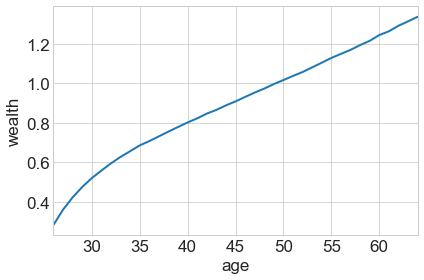

In [5]:
smd.plot({'data':moment_names},{'data':datamoms},xlabel='age',ylabel='wealth',hide_legend=True)

# Estimate the model

In [6]:
model = ConsumptionSavingModelClass(name='estimated',solmethod='egm',**par)

Choose **weighting matrix**:

In [7]:
if weighting_matrix == 0:
    W = np.eye(smd.datamoms.size) # identity
elif weighting_matrix == 1:
    W = np.diag(1.0/np.diag(smd.Omega)) # inverse of variance on the diagonal
else:
    W = np.linalg.inv(smd.Omega) # optimal weighting matrix

## Estimation results

In [8]:
# a. estimate the model (can take several minutes)
%time est = smd.estimate(model,W)

# b. print estimation results
print(f'\n       True  Est. ')
for key in est_par.keys():
    print(f'{key:5s} {getattr(true.par,key):2.3f} {est[key]:2.3f}')

objective function at starting values: 5.961003893464155
Wall time: 47.7 s

       True  Est. 
rho   2.000 2.018
beta  0.960 0.960


Show **model-fit**:

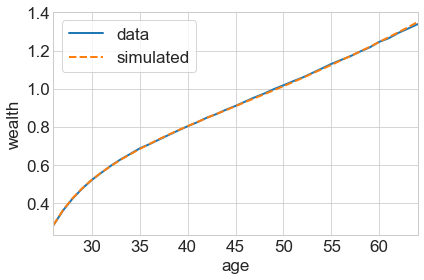

In [9]:
plot_data_x = {'data':moment_names,'simulated':moment_names}
plot_data_y = {'data':datamoms,'simulated':mom_func(model.sim)}
smd.plot(plot_data_x,plot_data_y,xlabel='age',ylabel='wealth')

## Standard errors

The SMD estimator is **asymptotic Normal** and standard errors have the same form as standard GMM estimators scaled with the adjustment factor $(1+S^{-1})$ due to the fact that we use $S$ simulations of the model.

The **standard errors** are thus 

$$
\begin{align}
\text{Var}(\hat{\theta})&=(1+S^{-1})\Gamma\Omega\Gamma'/N \\
\Gamma &= -(G'WG)^{-1}G'W \\
\Omega & = \text{Var}(m(\theta_0|w_i))
\end{align}
$$

where $G=\frac{\partial g(\theta)}{\partial \theta}$ is the $J\times K$ **Jacobian** with respect to $\theta$. $\Gamma$ is related to what is sometimes called the "influence function".

**Calculating $\Omega$**:

1. Can sometimes be done **analytically**
2. Can always be done using a **bootstrap** as done above

**Calculating the Jacobian, $G$:** This is done using numerical finite differences.

In [10]:
# a. number of datasets simulated per individual in original data
S = model.par.simN/N 

# b. find standard errors
Gamma, grad_theta = smd.calc_influence_function(est['theta'],model,W)
Var_theta = (1.0+1.0/S) * Gamma @ smd.Omega @ Gamma.T /N
se = np.sqrt(np.diag(Var_theta))

# b. print estimation results
print(f'       True  Est.  (se)')
for i,(key,val) in enumerate(est_par.items()):
    print(f'{key:5s} {getattr(true.par,key):2.3f} {est[key]:2.3f} ({se[i]:2.3f})')

       True  Est.  (se)
rho   2.000 2.018 (0.043)
beta  0.960 0.960 (0.001)


# Sensitivity Analysis

We now look into a **sensitivity analysis** of our estimation. Concretely, we implement the **informativeness measure** from [Honoré, Jørgensen and de Paula (2019)](https://arxiv.org/abs/1907.02101v2 "The Informativeness of Estimation Moments") and the **sensitivity to calibrated parameters** in [Jørgensen (2020)](https://www.dropbox.com/s/g8ip7h051dyhn3r/Sensitivity.pdf?dl=0). Further details can be found in these papers.

## The informativeness of estimation moments

The measures are motivated by those proposed in [Honoré, Jørgensen and de Paula (2019)](https://arxiv.org/abs/1907.02101v2 "The Informativeness of Estimation Moments"). All the measures proposed in that paper is calculated, but we will focus on their measure 4 that asks **"what is the change in the asymptotic variance from completely excluding the k'th moment?"**. If the *k*th is very informative about a parameter, the asymptotic varaince of that parameter should increase significantly, if we leave out the *k*th moment.

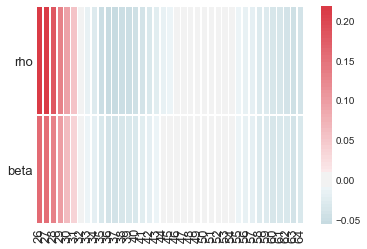

In [11]:
info = smd.informativeness_moments(grad_theta,smd.Omega,W)
smd.plot_heat(info['M4e'],est_par_names,moment_names,annot=False)

**Conclusion:** We can see that especially the wealth level for younger households are very informative regarding both $\rho$ and $\beta$. This is likely due to the fact that for low level of resources (which is the case at younger ages), the value of both these parameters affect consumption and saving decisions a lot. Thus, the level of saving especially in young ages are very informative and help to identify the two parameters.

## Sensitivity to calibrated parameters

The mesure is motivated by the one proposed in [Jørgensen (2020)](www.tjeconomics.com "Sensitivity to Calibrated Parameters"). Note that the estimation moments are all functions of the $L$ calibrated parameters, which we will denote $\gamma$, $g(\theta|\gamma)$. 

The **sensitivity measure** is defined as

$$
\begin{align}
S &= \Gamma D
\end{align}
$$

where $D=\frac{\partial g(\theta|\gamma)}{\partial \gamma}$ is the $J\times L$ **Jacobian** with respect to $\gamma$. 

*We only need to calculate $D$* since we have already calculated $\Gamma$ when we calculated standard errors above. We use numerical finite differences to calcualte this object.

**Chosen calibrated paramters:** $R$, $G$, $\sigma_{\psi}$, $\sigma_{\xi}$.

In [12]:
cali_par_names = ('R','G','sigma_psi','sigma_xi')
cali_par = np.array([getattr(model.par,name) for name in cali_par_names])

**Calculate the sensitivty measure:**

In [13]:
grad_gamma = smd.num_grad(cali_par,model,cali_par_names)
sens_cali = Gamma @ grad_gamma

**Plot sensitivity measure**

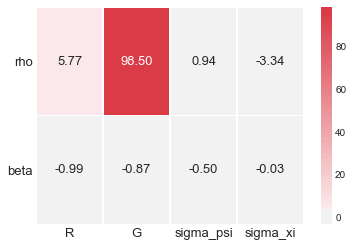

In [14]:
smd.plot_heat(sens_cali,est_par_names,cali_par_names)

**Check:** We can compare this to a brute-force approach in which we re-estimate the model for marginal changes in the calibrated parameters. This takes considerable time, however. The results are almost identical.

now re-estimating with R = 1.040010 (original 1.040000)
objective function at starting values: 5.981825671737618
now re-estimating with G = 1.020010 (original 1.020000)
objective function at starting values: 5.9290807517789235
now re-estimating with sigma_psi = 0.100010 (original 0.100000)
objective function at starting values: 5.97261798276576
now re-estimating with sigma_xi = 0.100010 (original 0.100000)
objective function at starting values: 5.961766998288387


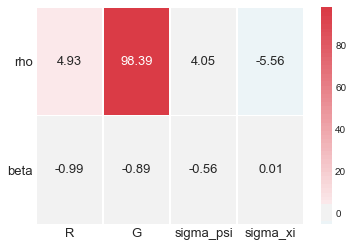

In [15]:
sens_cali_brute = smd.sens_cali_brute_force(model,est['theta'],W,cali_par_names)
smd.plot_heat(sens_cali_brute,est_par_names,cali_par_names)

**Arbitrary changes in $\gamma$**: We can also investigate larger simultaneous changes in $\gamma$.

In [16]:
# a. set new calibrated parameters
cali_par_new = {'G':1.05}

# b. update calibrated parameters in new version of the model
model_new = model.copy()
for key,val in cali_par_new.items():
    setattr(model_new.par,key,val)

# c. calculate new objective function
obj_vec = smd.diff_vec_func(est['theta'],model,est_par_names)
obj_vec_new = smd.diff_vec_func(est['theta'],model_new,est_par_names)

# d. approximate change in theta
Gamma_new,_ = smd.calc_influence_function(est['theta'],model_new,W)
theta_delta =  Gamma_new @ obj_vec_new - Gamma @ obj_vec

# e. extrapolate the gradient
theta_delta_extrap = np.zeros(theta_delta.size)
for j,key in enumerate(cali_par_new):
    theta_delta_extrap += sens_cali[:,j]*(cali_par_new[key]-getattr(model.par,key))

print(theta_delta_extrap)

[ 0.17300506 -0.02961878]


**Check:** Again, we can compare this approximation to a brute-force re-estimation of the model for the changed $\gamma$.

In [17]:
est_new = smd.estimate(model_new,W)
theta_delta_brute = est_new['theta'] - est['theta']
print(theta_delta_brute)

objective function at starting values: 5.463540643940908
[ 0.11275468 -0.05969197]
